In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_cora import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.gcn import StructuralOmegaGCNCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logs_filename = 'logs/omega_function/cora/05-1-structural_gcn_cossim_gamma_function.log'

In [4]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename=logs_filename
)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [7]:
dataset = load_dataset()

In [8]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [9]:
data = prepare_adjencency(data)

## Training

In [10]:
for run in range(30):
    for n_layers_gcn in range(1, 4):
        omega = StructuralOmegaGCNCosSim(
            device,
            dataset='cora',
            in_channels=data.x.shape[1],
            n_layers_gcn=n_layers_gcn,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y.reshape(-1, 1),
                    data.adj_t)

## Results

### For a Layer Number

In [11]:
n_layers_gcn = 1

In [12]:
metrics = StructuralOmegaGCNCosSim.read_metrics(
    dataset='cora',
    n_layers_gcn=n_layers_gcn)
print(metrics.shape)
metrics.head()

(205, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.628072,0.664155,0.669945,0.610461,0.616094,0.618339
1,0,50,0.568294,0.584475,0.601121,0.735657,0.742842,0.714291
2,0,100,0.556499,0.572596,0.590719,0.747640,0.750378,0.724650
3,0,150,0.548890,0.565818,0.584475,0.755019,0.755409,0.731230
4,0,200,0.541258,0.561565,0.582694,0.767071,0.765237,0.738733


### Sumarize metrics per epoch

In [13]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [14]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [15]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.628288,0.000281,0.664474,0.000404,0.670290,0.000421,0.609653,0.002569,0.615222,0.003448,0.616794,0.003263
50,0.568495,0.000415,0.584001,0.000685,0.600298,0.000744,0.733554,0.001279,0.741682,0.000742,0.714101,0.000396
100,0.556743,0.000456,0.573462,0.001262,0.591863,0.001649,0.748373,0.001218,0.750924,0.000674,0.724053,0.000733
150,0.549202,0.000336,0.567087,0.001405,0.586534,0.002246,0.757061,0.002041,0.757450,0.002015,0.731247,0.000356
200,0.541636,0.000714,0.561140,0.001524,0.581693,0.001940,0.765320,0.001744,0.764100,0.001259,0.738282,0.000986


In [16]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
1900,0.508203,0.000411,0.537285,0.000359,0.559487,0.000499,0.786178,0.000441,0.781083,0.000473,0.760430,0.000573
2000,0.508014,0.000405,0.537455,0.000580,0.559742,0.000435,0.785997,0.000571,0.780789,0.000263,0.760204,0.000191
1500,0.509656,0.001641,0.537957,0.000953,0.559859,0.001011,0.785922,0.000642,0.780787,0.000411,0.759773,0.000919
1750,0.508298,0.000392,0.537454,0.000907,0.559830,0.001030,0.786363,0.000300,0.780774,0.000446,0.759679,0.000802
1250,0.510506,0.000953,0.537718,0.000397,0.559404,0.000947,0.784711,0.000890,0.780697,0.000670,0.760042,0.000872


/tmp/ipykernel_56029/2011208556.py:29: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_56029/2011208556.py:77: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



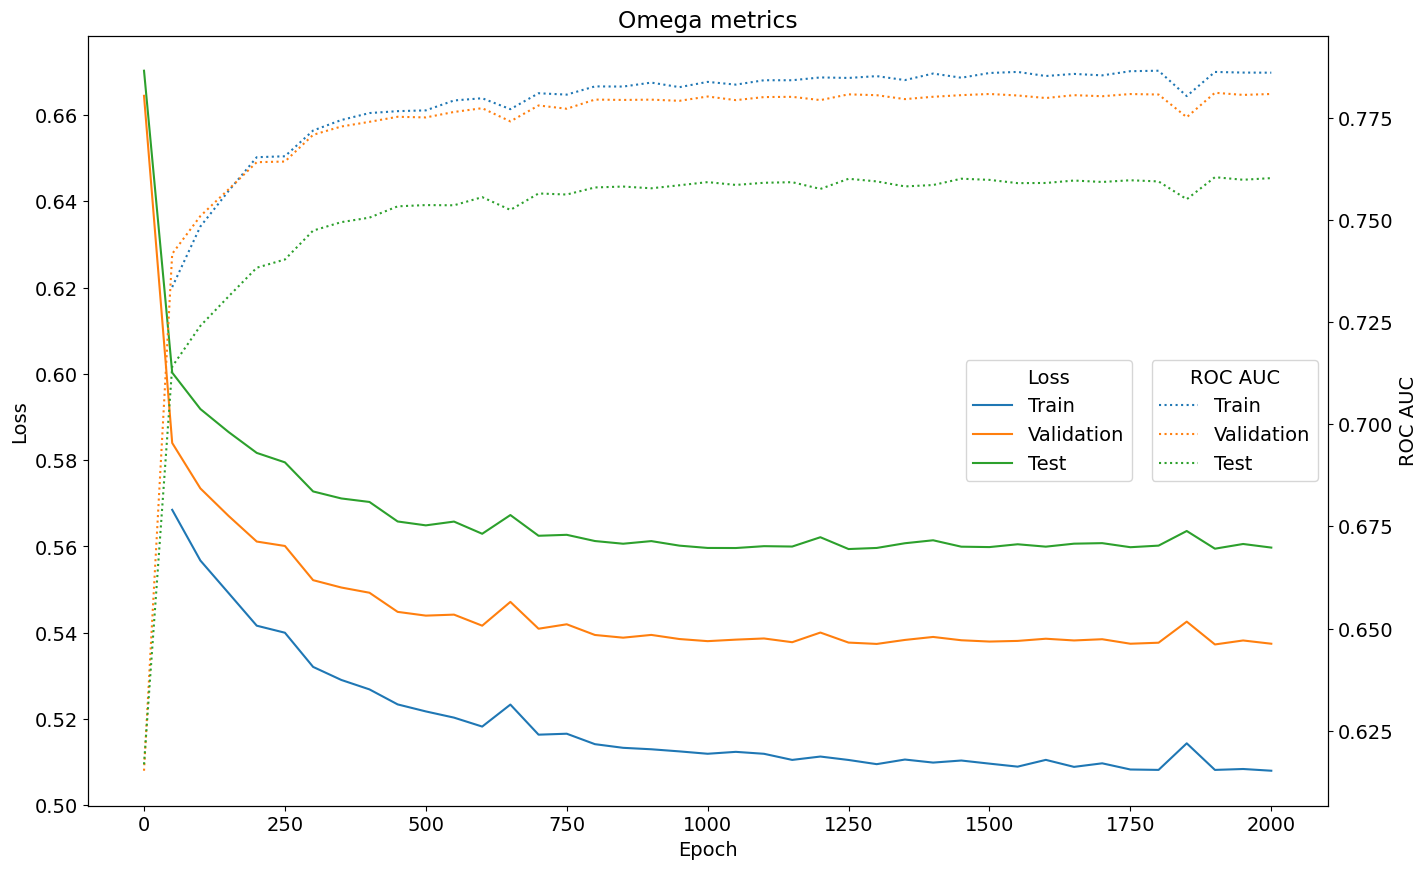

In [17]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

# ax1.errorbar(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.plot(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    # yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.plot(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    # yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.plot(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    # yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

# ax2.errorbar(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.plot(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    # yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.plot(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    # yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.plot(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    # yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/structural_omega_gcn_cossim_training_metrics_{n_layers_gcn}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [18]:
n_layers_list = range(1, 4)

In [19]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_gcn in n_layers_list:
    metrics = StructuralOmegaGCNCosSim.read_metrics(n_layers_gcn=n_layers_gcn)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_gcn] = auc_val
    mean_loss_val_dict[n_layers_gcn] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_gcn] = auc_val
    std_loss_val_dict[n_layers_gcn] = loss_val

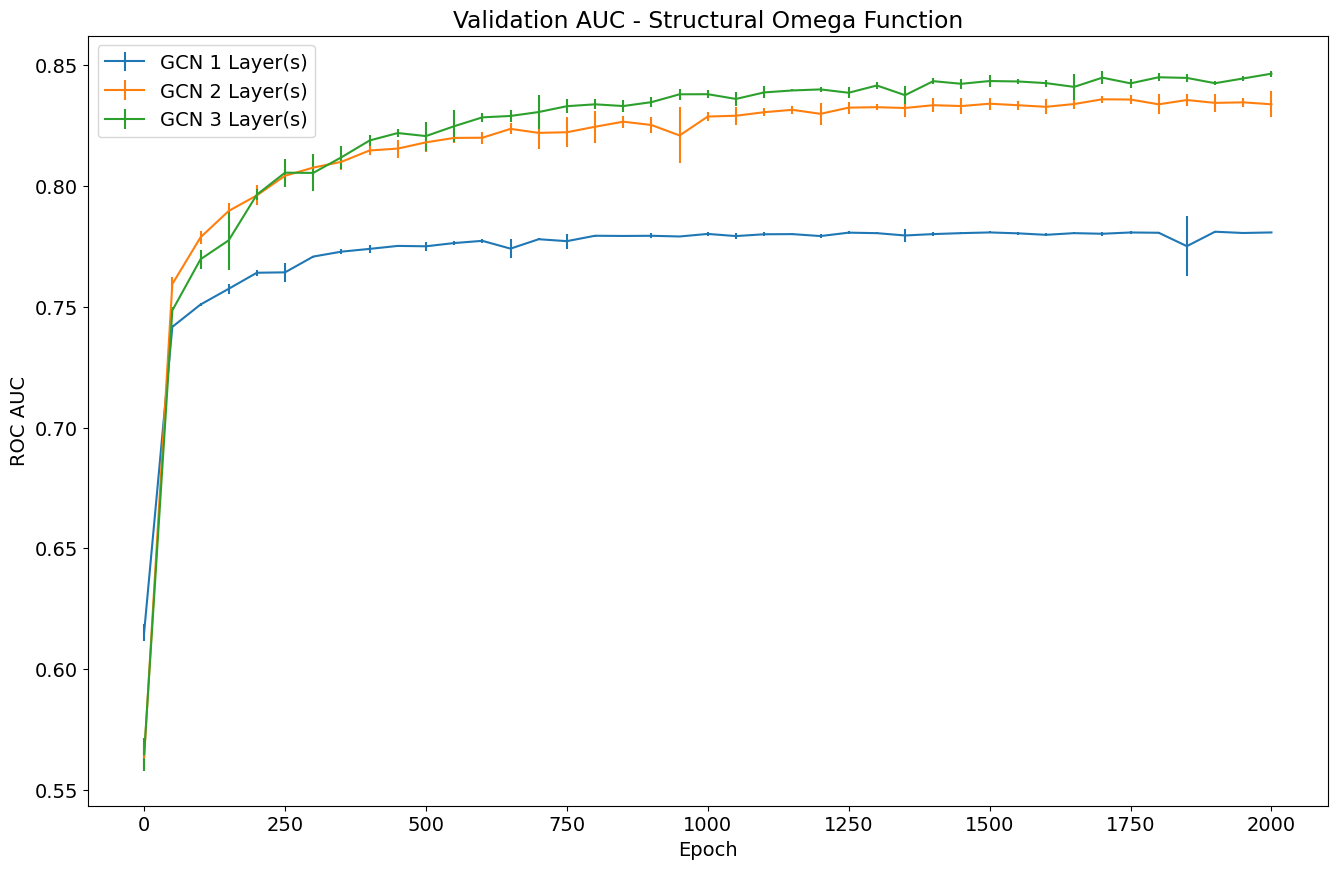

In [22]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'GCN {n_layers} Layer(s)')

# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [23]:
n_layers_list = range(1, 4)

In [24]:
full_metrics = []
for n_layers_gcn in n_layers_list:
    metrics = StructuralOmegaGCNCosSim.read_metrics(
        n_layers_gcn=n_layers_gcn)
    metrics['n_layers_gcn'] = n_layers_gcn
    full_metrics.append(metrics)
full_metrics = pd.concat(full_metrics)

In [25]:
best_model_metrics = full_metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run                0.000000
epoch           2000.000000
loss_train         0.422013
loss_val           0.469986
loss_test          0.501619
auc_train          0.868521
auc_val            0.848179
auc_test           0.825696
n_layers_gcn       3.000000
Name: 40, dtype: float64

In [26]:
best_model_metrics.to_json('models/structural_omega_grapn_sage_cossim/best_model_info.json')

### Load data

In [27]:
dataset = load_dataset()
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)
data = prepare_adjencency(data)

### Load model

In [29]:
omega = StructuralOmegaGCNCosSim.load_model(
    run=int(best_model_metrics['run']),
    epoch=int(best_model_metrics['epoch']),
    device=device,
    n_layers_gcn=int(best_model_metrics['n_layers_gcn']))

### Score model

In [30]:
all_edges = torch.concat([edges_train, edges_val, edges_test], dim=1)
all_edges.shape

torch.Size([2, 1166243])

In [31]:
preds = omega.forward(all_edges, data.x, data.adj_t).to('cpu').detach().numpy()
preds[:5]

array([[0.8679071 ],
       [0.49644396],
       [0.07509475],
       [0.484338  ],
       [0.35505143]], dtype=float32)

In [32]:
theta = omega.is_same_class(all_edges, data.y).to('cpu').detach().numpy()

In [33]:
roc_auc_score(theta, preds)

0.8475192161947509

In [34]:
theta.mean()

0.655083031580897

In [35]:
preds.mean()

0.74753404

### Save output

In [36]:
cpu_edges = all_edges.to('cpu').numpy()
edges_gamma_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'gamma_pred': preds[:,0]
})
print(edges_gamma_df.shape)
edges_gamma_df.head()

(1166243, 3)


,source,target,gamma_pred
0,104447,13091,0.867907
1,15858,47283,0.496444
2,107156,69161,0.075095
3,107156,136440,0.484338
4,107156,107366,0.355051


In [37]:
os.makedirs('data/structural_omega_gcn_cossim', exist_ok=True)
edges_gamma_df.to_csv('data/structural_omega_gcn_cossim/05-1_omega_scored_edges.csv', index=False)

Text(0.5, 1.0, 'Omega distribution over all edges')

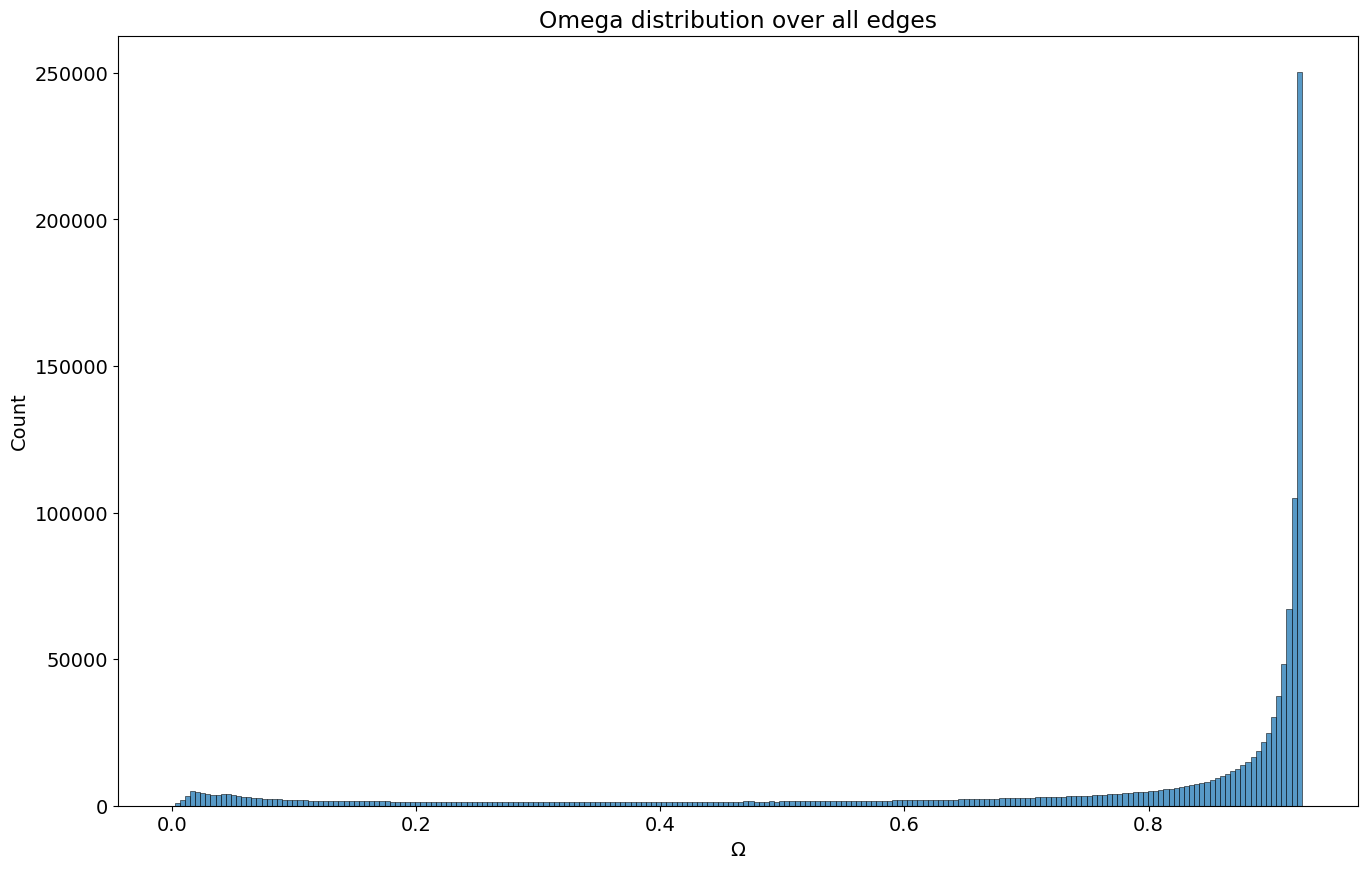

In [38]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_gamma_df['gamma_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
# plt.savefig('reports/images/best_omega_distribution.png')